<a href="https://colab.research.google.com/github/TaiDuc1001/Manipulating-Face-Attributes-with-VAE/blob/master/VAE_Faces_Attributes_Manipulating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils
from torchsummary import summary
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import time
import multiprocessing as mp
import pickle

In [ ]:
!unzip -qq '/content/drive/MyDrive/CelebA/Img/img_align_celeba.zip' -d 'celeba'

In [ ]:
image_size = 112
batch_size = 128

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

class CelebADataset(Dataset):
    def __init__(self, image_dir, attr_file, transform=None):
        self.image_dir = image_dir
        self.attr_file = attr_file
        self.transform = transform
        self.attribute = pd.read_csv(attr_file, delim_whitespace=True, skiprows=1)

    def __len__(self):
        return len(self.attribute)

    def show(self, idx):
      image, attributes = self[idx]
      label = random.choice(attributes)

      # Inverse normalization if necessary
      if self.transform is not None:
          if isinstance(self.transform, transforms.Compose):
              for tr in self.transform.transforms:
                  if isinstance(tr, transforms.Normalize):
                      mean = torch.tensor(tr.mean)
                      std = torch.tensor(tr.std)
                      image = image * std[:, None, None] + mean[:, None, None]
          elif isinstance(self.transform, transforms.Normalize):
              mean = torch.tensor(self.transform.mean)
              std = torch.tensor(self.transform.std)
              image = image * std[:, None, None] + mean[:, None, None]

      image = image.permute(1, 2, 0).numpy()
      plt.imshow(image)
      plt.axis("off")
      plt.title(label)
      plt.show()

    def __getitem__(self, idx):
      if isinstance(idx, slice):
        images, attributes_list = [], []
        indices = range(*idx.indices(len(self)))
        for i in indices:
          image, attribute = self[i]
          images.append(image)
          attributes_list.append(attribute)
        return images, attributes_list

      else:
        img_name = self.attribute.index[idx]
        image = Image.open(os.path.join(self.image_dir, str(img_name)))
        if self.transform:
            image = self.transform(image)
        observation = self.attribute.iloc[idx]
        attributes = observation[observation==1].index.tolist()
        label = random.choice(attributes)

        return image, label

# Initialize dataset and dataloader
image_dir = '/content/celeba/img_align_celeba'
attr_file = '/content/drive/MyDrive/CelebA/Anno/list_attr_celeba.txt'
dataset = CelebADataset(image_dir, attr_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class Encoder(nn.Module):
  def __init__(self, z_dim, features):
    super().__init__()
    def block(in_channels, out_channels, kernel_size, stride, padding=1):
      layers = []
      layers.extend([
          nn.Conv2d(in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding),
          # nn.BatchNorm2d(num_features=out_channels),
          nn.ReLU(),
          nn.Dropout(0.2)
      ])
      return layers

    self.feature_extractor = nn.Sequential(
        *block(3, features*1, 3, 2, 1),
        *block(features*1, features*2, 3, 2, 1),
        *block(features*2, features*4, 3, 2, 1),
        *block(features*4, features*8, 3, 2, 1),
        *block(features*8, features*4, 3, 1, 1)
    )
    self.z_dim = z_dim

    self.mu = nn.Linear(features*4*7*7, self.z_dim)
    self.logvar = nn.Linear(features*4*7*7, self.z_dim)

  def forward(self, x):
    x = self.feature_extractor(x)
    x = x.view(-1, features*4*7*7)
    mu = self.mu(x)
    logvar = self.logvar(x)
    epsilon = torch.randn(self.z_dim).to(device)
    z = mu + torch.exp(0.5*logvar)*epsilon
    return z, mu, logvar

In [ ]:
class Decoder(nn.Module):
  def __init__(self, z_dim, features):
    super().__init__()
    def block(in_channels, out_channels, kernel_size, stride, padding, last_layer=False):
      layers = []
      if not last_layer:
        layers.extend([
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='bilinear')
        ])
      else:
        layers.extend([
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.Sigmoid()
        ])

      return layers
    self.fc1 = nn.Linear(z_dim, features*2*7*7)
    self.upsampling = nn.Sequential(
        *block(features*2, features*4, 3, 1, 1), #(64, 14, 14)
        *block(features*4, features*8, 3, 1, 1), #(64, 28, 28)
        *block(features*8, features*4, 3, 1, 1), #(32, 56, 56)
        *block(features*4, features*2, 3, 1, 1), #(32, 112, 112)
        *block(features*2, 3, 3, 1, 1, last_layer=True) #(3, 112, 112)
    )
  def forward(self, x):
    x = self.fc1(x)
    x = x.view(-1, features*2, 7, 7)
    x = self.upsampling(x)
    return x

In [ ]:
class VAE(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
  def forward(self, x):
    z, mu, logvar = self.encoder(x)
    x = self.decoder(z)
    return x, mu, logvar

In [ ]:
epochs = 20

def KL_loss(mu, logvar):
  kl_loss = -0.5*torch.mean(logvar - torch.exp(logvar) - mu**2 + 1)
  return kl_loss

def reconstruction_loss(generated_tensor, true_tensor):
  rc_loss = torch.mean((generated_tensor*255. - true_tensor*255.)**2)
  return rc_loss

In [ ]:
epochs = 20
features = 64
z_dim = 200
device='cuda' if torch.cuda.is_available() else 'cpu'
kl_weight = 1e-2
rc_weight = 1

encoder = Encoder(z_dim, features).to(device)
decoder = Decoder(z_dim, features).to(device)
vae = VAE(encoder, decoder).to(device)
summary(vae, (3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,792
              ReLU-2           [-1, 64, 56, 56]               0
           Dropout-3           [-1, 64, 56, 56]               0
            Conv2d-4          [-1, 128, 28, 28]          73,856
              ReLU-5          [-1, 128, 28, 28]               0
           Dropout-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 256, 14, 14]         295,168
              ReLU-8          [-1, 256, 14, 14]               0
           Dropout-9          [-1, 256, 14, 14]               0
           Conv2d-10            [-1, 512, 7, 7]       1,180,160
             ReLU-11            [-1, 512, 7, 7]               0
          Dropout-12            [-1, 512, 7, 7]               0
           Conv2d-13            [-1, 256, 7, 7]       1,179,904
             ReLU-14            [-1, 25

In [ ]:
main_path = '/content/drive/MyDrive/VAEs/VAE Faces Attributes Manipulating'
outputs_folder = 'Training Outputs'
outputs_path = os.path.join(main_path, outputs_folder)

# Fixed grid
images, _ = dataset[:7]
print(images[6].shape)

def visualize(epoch, batch_index, images=images, outputs_path=outputs_path, num_epochs=epochs, loader=dataloader):
  global figs
  images = torch.stack(images)
  with torch.no_grad():
    generated_tensor, _, _ = vae(images.to(device))
  predicts = vutils.make_grid(generated_tensor.detach(), nrow=7, padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0))
  fixed_grid = vutils.make_grid(images.detach(), padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0))

  fig = plt.figure(figsize=(10, 3))
  plt.subplot(2, 1, 1)
  plt.imshow(fixed_grid)
  plt.axis("off")

  plt.subplot(2, 1, 2)
  plt.imshow(predicts)
  plt.axis("off")

  plt.suptitle(f"[{epoch}/{num_epochs}][{index}/{len(loader)}]")
  plt.subplots_adjust(hspace=0.0)

  plt.show()
  img_path = os.path.join(outputs_path, f'[{epoch}-{epochs}][{batch_index}-{len(loader)}].png')
  fig.savefig(img_path)
  figs.append(fig)

torch.Size([3, 112, 112])


In [ ]:
# main train
# lr = 1e-3
# Note: giảm lr còn 1 nửa
lr = 5e-4
opt = optim.Adam(vae.parameters(), lr=lr)
last_epoch = 12
vae_model_file = f'VAE_{last_epoch}.pth'
vae_model_file = os.path.join(main_path, vae_model_file)
vae.load_state_dict(torch.load(vae_model_file))

generated_grids, original_grids = [], []
losses, kl_losses, rc_losses = [], [], []
figs = []

save_interval = 100
for epoch in range(last_epoch + 1, epochs + 1):
  vae.train()
  for batch_idx, (images, _) in enumerate(dataloader):
    images = images.to(device)
    outputs, mu, logvar = vae(images)
    kl_loss = KL_loss(mu, logvar)
    rc_loss = reconstruction_loss(outputs, images)
    loss = kl_weight * kl_loss + rc_weight * rc_loss
    vae.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())
    kl_losses.append(kl_loss.item())
    rc_losses.append(rc_loss.item())

    index = batch_idx
    if index%10==0:
      print(f"[{epoch}/{epochs}][{index}/{len(dataloader)}]\tKL_Loss={kl_loss.item():.8f}\tRC_Loss={rc_loss.item():.8f}\tLoss={loss.item():.8f}")

    if index % save_interval == 0:
      visualize(epoch, index)


    if (batch_idx <= 200) and (epoch == 0):
      save_interval = 10
    else:
      save_interval = 100


Note:
- epoch 13 loss có vẻ tăng.
- epoch 13 14 loss khá bất ổn, lên xuống.
- khả năng là do nó gần tới điểm hội tụ, nhưng learning rate cao nên đi lố, maybe.
- --> Quyết định sau epoch `14-1` sẽ train tiếp tục nhánh `15-1` (dựa trên 2 epoch lỗi này) bằng cách giảm learning rate xuống còn 5e-4.
- Nếu sau full epoch 15.1 loss không giảm sẽ quay trở về epoch 13 mà giảm learning_rate.
- Vậy tên của epoch 13 14 lỗi này sẽ là `13-1` và `14-1`.
- **Nếu sau epoch `13` learning rate vẫn ko tiến triển sẽ dừng training tại epoch `12`.**

Update:
- Quyết định xoá luôn epoch `13-1` và `14-1` vì train bất ổn định. -> Sẽ ko save gì cả.

In [ ]:
# Standard writing mode
vae_model_file = f'VAE_{last_epoch+1}.pth'
vae_model_file = os.path.join(main_path, vae_model_file)
pickle_file = 'img_list.pkl'

img_list_full_path = os.path.join(main_path, pickle_file)

# Save generated and original tensors to a pickle file

# Save img_list to a file
with open(img_list_full_path, 'ab') as f:
    pickle.dump(figs, f)

# Save losses into a file
loss_file = 'loss_analysis.csv'
loss_file_path = os.path.join(main_path, loss_file)

with open(loss_file_path, 'a') as f:
    # f.write("Epoch,Batch_idx,KL_loss,RC_loss,Total_loss\n")
    for index, (kl_loss, rc_loss, total_loss) in enumerate(zip(kl_losses, rc_losses, losses)):
        epoch = index // len(dataloader)
        batch_idx = index % len(dataloader)
        f.write(f"{epoch},{batch_idx},{kl_loss},{rc_loss},{total_loss}\n")

# Save model
torch.save(vae.state_dict(), vae_model_file)

In [ ]:
# Later, to load img_list from the file
with open(img_list_full_path, 'rb') as f:
    img_list = pickle.load(f)

# Accessing the data
generated_grids = img_list['generated_grids']
original_grids = img_list['original_grids']

### Smiling Vector

In [ ]:
def show(tensor):
  tensor = tensor.detach().numpy().squeeze().transpose((1, 2, 0))
  plt.imshow(tensor)
  plt.axis("off")
  plt.show()

In [ ]:
# Original algorithm to calculate vector
attribute='Smiling'

smiling_in, not_smiling_in = [], []
slices = 2**15
images, attributes_list = dataset[:slices]
for image, attributes in zip(images, attributes_list):
  if attribute in attributes:
    smiling_in.append(image)
  else:
    not_smiling_in.append(image)

smiling_out, not_smiling_out = [], []
_, mu, _ = vae(torch.stack(smiling_in).cuda())
_, neg_mu, _ = vae(torch.stack(not_smiling_in).cuda())

avg_mu = torch.mean(mu, axis=0).detach()
avg_neg_mu = torch.mean(neg_mu, axis=0).detach()

target_vector = avg_mu - avg_neg_mu

KeyboardInterrupt: 

In [ ]:
# ChatGPT algorithm to calculate target vector

# Define batch size
batch_size = 32
attribute='Smiling'

smiling_in, not_smiling_in = [], []
slices = 2**12
images, attributes_list = dataset[:slices]
for image, attributes in zip(images, attributes_list):
  if attribute in attributes:
    smiling_in.append(image)
  else:
    not_smiling_in.append(image)

# Initialize lists to store results
smiling_out, not_smiling_out = [], []


# Process dataset in batches
for i in range(0, len(smiling_in), batch_size):
    # Get a batch of smiling images
    batch_smiling = torch.stack(smiling_in[i:i+batch_size]).cuda()
    # Get a batch of not smiling images
    batch_not_smiling = torch.stack(not_smiling_in[i:i+batch_size]).cuda()

    # Pass batch through the VAE
    _, mu, _ = vae(batch_smiling)
    _, neg_mu, _ = vae(batch_not_smiling)

    # Calculate average mu for each batch
    avg_mu_batch = torch.mean(mu, axis=0).detach()
    avg_neg_mu_batch = torch.mean(neg_mu, axis=0).detach()

    # Accumulate results
    smiling_out.append(avg_mu_batch)
    not_smiling_out.append(avg_neg_mu_batch)

# Calculate overall average mu and neg_mu
avg_mu = torch.mean(torch.stack(smiling_out), dim=0)
avg_neg_mu = torch.mean(torch.stack(not_smiling_out), dim=0)

# Calculate target vector
target_vector = avg_mu - avg_neg_mu

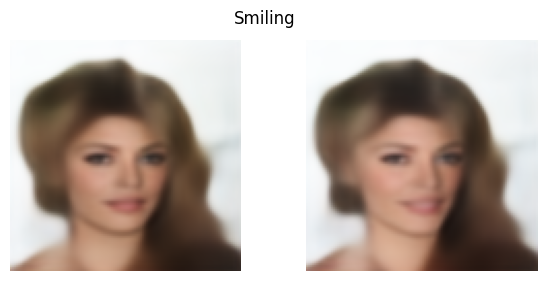

In [ ]:
def view_changes(index, vector, attribute, z_dim, negative=False):
  origin, attributes = dataset[index]
  origin_out, mu, logvar = vae(origin.unsqueeze(0).cuda())
  if negative:
    new_mu = mu - vector
  else:
    new_mu = mu + vector
  modified = new_mu + torch.exp(0.5*logvar)*torch.randn(z_dim).cuda()
  modified_out = decoder(modified)

  origin_out = origin_out.detach().cpu().numpy().squeeze().transpose((1, 2, 0))
  modified_out = modified_out.detach().cpu().numpy().squeeze().transpose((1, 2, 0))

  plt.figure(figsize=(7, 3))
  plt.subplot(1, 2, 1)
  plt.imshow(origin_out)
  plt.axis("off")
  plt.subplot(1, 2, 2)
  plt.imshow(modified_out)
  plt.axis("off")
  plt.suptitle(attribute)
  plt.show()

view_changes(index=5, vector=target_vector, attribute='Smiling', z_dim=z_dim, negative=False)

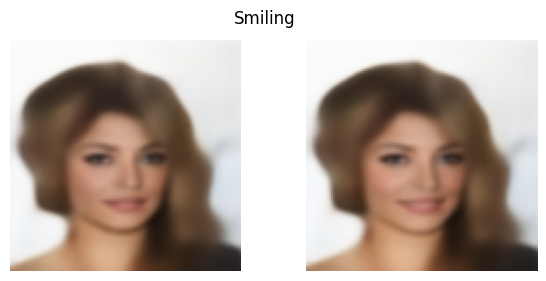

In [ ]:
view_changes(index=5, vector=target_vector, attribute='Smiling', z_dim=z_dim, negative=False)

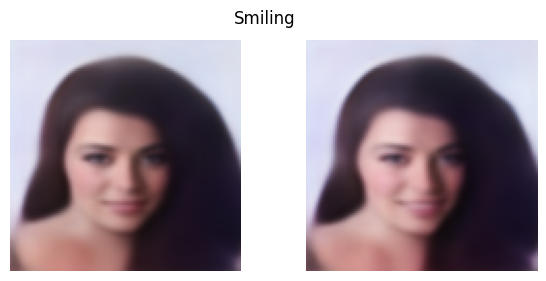

In [ ]:
view_changes(index=10, vector=target_vector, attribute='Smiling', z_dim=z_dim, negative=False)

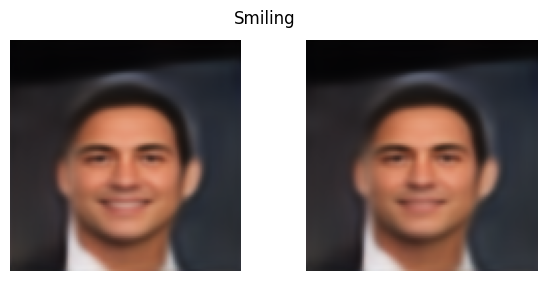

In [ ]:
view_changes(index=11, vector=target_vector, attribute='Smiling', z_dim=z_dim, negative=True)

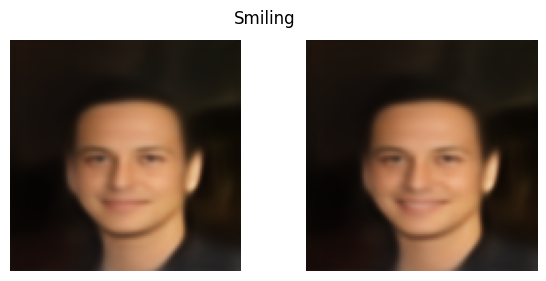

In [ ]:
view_changes(index=15, vector=target_vector, attribute='Smiling', z_dim=z_dim, negative=False)

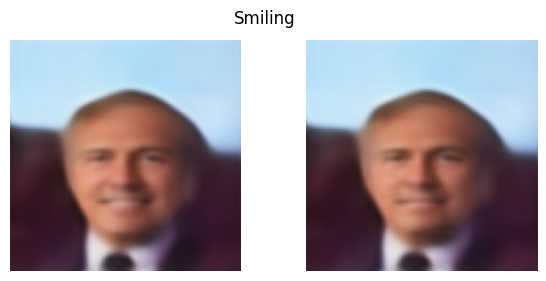

In [ ]:
view_changes(index=20, vector=target_vector, attribute='Smiling', z_dim=z_dim, negative=True)

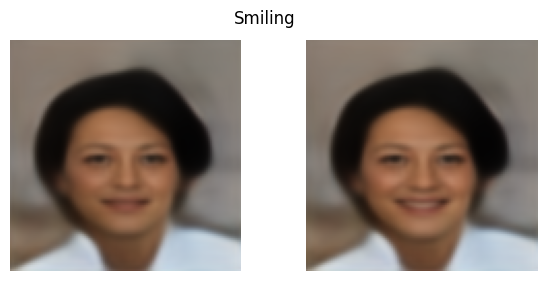

In [ ]:
view_changes(index=100, vector=target_vector, attribute='Smiling', z_dim=z_dim, negative=False)

### External images

In [ ]:
target_epoch = 12
vae_model_file = f'VAE_{target_epoch}.pth'
vae_model_file = os.path.join(main_path, vae_model_file)
vae.load_state_dict(torch.load(vae_model_file))

<All keys matched successfully>

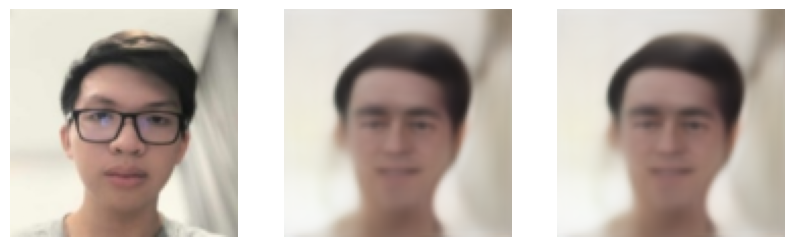

In [ ]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path)
    if transform:
        image = transform(image)
    return image

path = "/content/khang_nguyen_khong_cuoi_cropped.jpg"

origin = load_and_transform_image(path, transform).cuda()
origin_out, mu, logvar = vae(origin.unsqueeze(0))
# if negative:
# new_mu = mu - vector
# else:
# new_mu = mu + vector

modified = mu + torch.exp(0.5*logvar)*torch.randn(z_dim).cuda()
modified_out = decoder(modified)

origin_out = origin_out.detach().cpu().numpy().squeeze().transpose((1, 2, 0))
modified_out = modified_out.detach().cpu().numpy().squeeze().transpose((1, 2, 0))

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(origin.squeeze().cpu().numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(origin_out)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(modified_out)
plt.axis("off")
# plt.suptitle(attribute)
plt.show()

Note:
- Dùng ảnh Khang nguyễn ko thành công. Khả năng cao do dataset toàn người phương tây nên đưa ảnh ng châu á vào ko generate tốt.